Base on the work on the EDA, we can work on **recommending actions** to the company management. We can also use models such as ARIMA to **forecast future incomes**.

Here are some extra information to take into account.

# Summary of Problem Statement
## ❓ How could Olist improve its profit ❓

**P&L Rules**<br>
Revenues<br>
Sales fees: Olist takes a 10% cut on the product price (excl. freight) of each order delivered<br>
Subscription fees: Olist charges 80 BRL by month per seller


**IT costs** <br>
Olist's total cumulated IT Costs scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.<br>
<br>
𝐼𝑇_𝑐𝑜𝑠𝑡𝑠=𝛼∗$\sqrt{𝑛\_𝑠𝑒𝑙𝑙𝑒𝑟𝑠}$+𝛽∗$\sqrt{𝑛\_𝑖𝑡𝑒𝑚𝑠}$<br>
 
Olist's data team gave us the following values for these scaling parameters:<br>

𝛼=3157.27
 
𝛽=978.23<br>
 <br>
💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.<br>
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.<br>
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite<br>

with 1000 sellers and a total of 100 items sold, the total IT cost accumulates to 109,624 BRL<br>
with 100 sellers and a total of 1000 items sold, the total IT cost accumulates to 62,507 BRL<br>
Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

**Reputation cost**


_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```


In [57]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal  import seasonal_decompose
from statsmodels.tsa.stattools  import adfuller, kpss
from statsmodels.graphics.tsaplots  import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics  import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax  import SARIMAX

# Actual situation

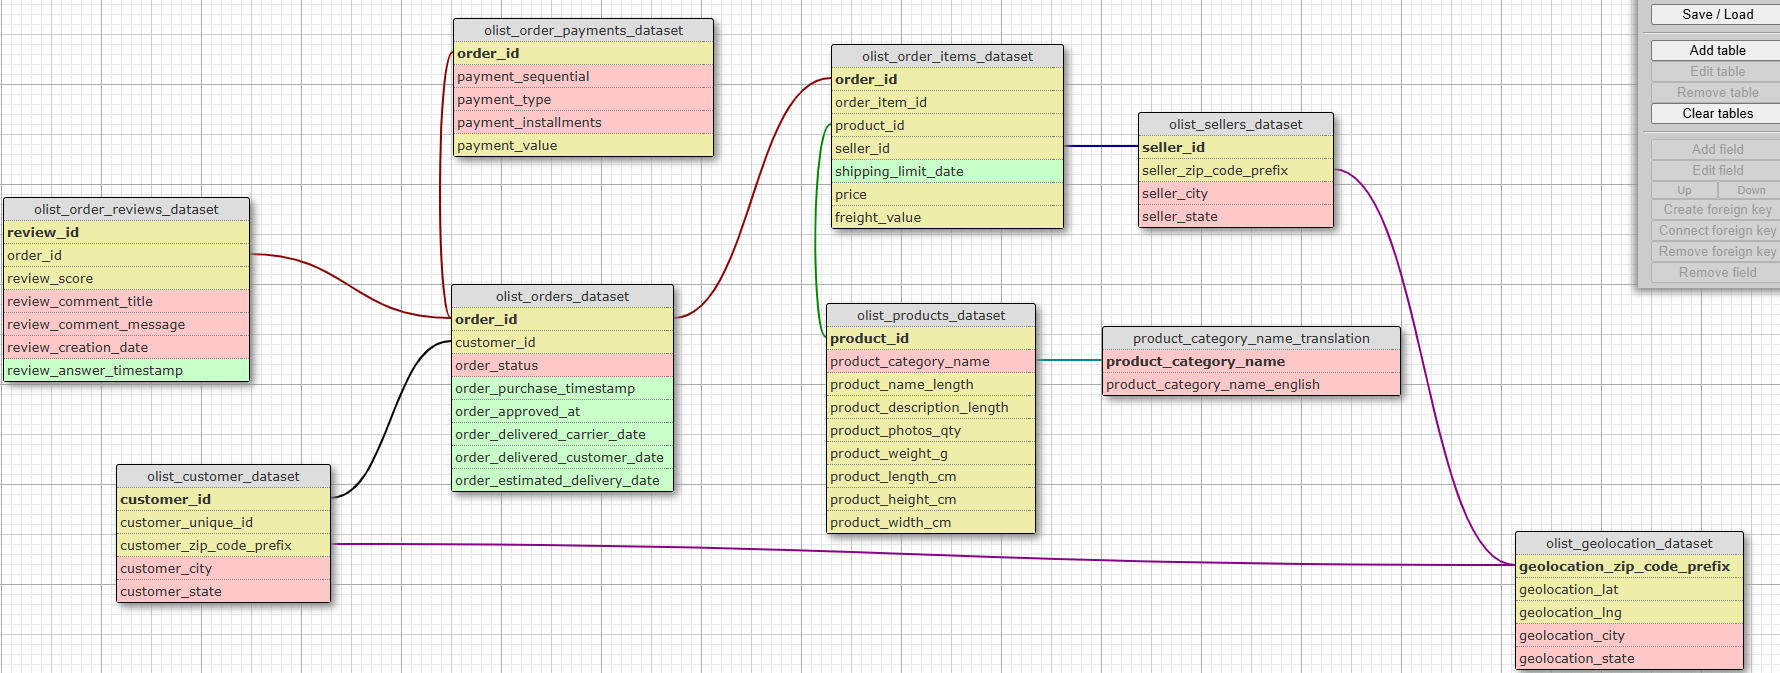

In [2]:
Image('Image/olist_erd_details.png')

In [3]:
# Load CSVs
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
translation = pd.read_csv('data/product_category_name_translation.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')

# Merge datasets 
data = orders.merge(customers, on='customer_id', how='left') \
    .merge(order_items, on='order_id', how='left') \
    .merge(sellers, on='seller_id', how='left') \
    .merge(reviews, on='order_id', how='left') \
    .merge(products, on='product_id', how='left') \
    .merge(translation, on='product_category_name', how='left')

# Transform order_purchase_timestamp in Datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Cleaning
# Drop columns not inherently related to the objectives, especially in the context of EDA
# drop columns with too many missing values

data = data.drop(columns=['order_delivered_carrier_date','order_approved_at', 'review_id','review_comment_title', 
                         'review_answer_timestamp', 'product_name_lenght', 'product_description_lenght',
                         'product_photos_qty','product_weight_g', 'product_length_cm', 'product_height_cm','product_width_cm',
                         'product_category_name', 'customer_id', 'order_delivered_customer_date', 
                         'order_estimated_delivery_date','seller_city','seller_zip_code_prefix', 'seller_state','customer_city','review_comment_message'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114092 non-null  object        
 1   order_status                   114092 non-null  object        
 2   order_purchase_timestamp       114092 non-null  datetime64[ns]
 3   customer_unique_id             114092 non-null  object        
 4   customer_zip_code_prefix       114092 non-null  int64         
 5   customer_state                 114092 non-null  object        
 6   order_item_id                  113314 non-null  float64       
 7   product_id                     113314 non-null  object        
 8   seller_id                      113314 non-null  object        
 9   shipping_limit_date            113314 non-null  object        
 10  price                          113314 non-null  float64       
 11  

In [5]:
data.isna().sum()

order_id                            0
order_status                        0
order_purchase_timestamp            0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_state                      0
order_item_id                     778
product_id                        778
seller_id                         778
shipping_limit_date               778
price                             778
freight_value                     778
review_score                      961
review_creation_date              961
product_category_name_english    2414
dtype: int64

## Answer the problem

### Maximaze Revenue

Olist's revenue streams:

Sales Fees: 10% of product price (excluding freight) for delivered orders.

Subscription Fees: 80 BRL per month per seller.

In [6]:
## Total Sales Fees

# Only consider delivered orders
delivered_orders = data[data['order_status'] == 'delivered']

# Compute total sales fee (10% of price, not freight)
sales_fee = 0.10 * delivered_orders['price'].sum()
print(f'The incomes from the 10% cut on all sales made through the Olist platform is BRL:{sales_fee:,.2f}')

The incomes from the 10% cut on all sales made through the Olist platform is BRL:1,327,983.66


In [7]:
## Total Subscription Revenue

# Unique sellers
unique_sellers = data['seller_id'].nunique()

seller_orders = order_items.merge(orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')
seller_orders['order_purchase_timestamp'] = pd.to_datetime(seller_orders['order_purchase_timestamp'])


seller_lifespan = seller_orders.groupby('seller_id')['order_purchase_timestamp'] \
    .agg(['min', 'max']) \
    .rename(columns={'min': 'first_sale', 'max': 'last_sale'})

# Function to calculate number of months between two dates
def month_diff(d1, d2):
    rd = relativedelta(d2, d1)
    return rd.years * 12 + rd.months + (1 if rd.days > 0 else 0)

seller_lifespan['months_active'] = seller_lifespan.apply(lambda row: month_diff(row['first_sale'], row['last_sale']), axis=1)

# Subscription revenue = 80 BRL per active month per seller
subscription_revenue = (seller_lifespan['months_active'] * 80).sum()
print(f"Total Subscription Revenue: BRL {subscription_revenue:,.2f}")

Total Subscription Revenue: BRL 1,532,320.00


### Total Revenue

In [8]:
total_revenue = sales_fee + subscription_revenue
print(f"The Total Revenue of Olist is BRL {total_revenue:,.2f}")

The Total Revenue of Olist is BRL 2,860,303.66


### Calculate IT Costs

In [9]:
alpha = 3157.27
beta = 978.23

n_sellers = data['seller_id'].nunique()
n_items = data['order_item_id'].count() * 0.92

it_costs = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
print(f"The Total IT costs of Olist is BRL {it_costs:,.2f}")

The Total IT costs of Olist is BRL 491,494.47


*The IT department told us that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL. So it confirms our findings.* <br>
**Note**: We already realized that 95 % of the revenue comes from half of the categories, which represent 92% of the products.<br>
The new IT Cost would be BRL 491,494.47, so we won't look further in the idea of cutting products.

### Calculate Reputation cost

In [10]:
# How does the review scoring works, are these float or int?
data['review_score'].nunique()

5

In [11]:
def review_cost(x):
    if pd.isna(x):
        return 0  
    if x == 3:
        return 40
    elif x == 2:
        return 50
    elif x == 1:
        return 100
    else:
        return 0


In [12]:
data['review_cost']=data['review_score'].apply(lambda x: review_cost(x))
reputation_cost = data['review_cost'].sum()

In [13]:
print(f'Olist reputation cost is BRL {reputation_cost:,.2f}')

Olist reputation cost is BRL 2,053,340.00


### Profit = Revenue - IT Costs - Reputation score

In [14]:
profit = total_revenue - it_costs - reputation_cost
print(f'Olist profit is BRL {profit:,.2f}')

Olist profit is BRL 315,469.19


# Hypothesis
## *What if we remove the sellers that have bad reviews??*

### Identify Performant sellers

In [15]:
data['seller_id'].nunique()

3095

In [16]:
# Identify good sellers
good_sellers = data.groupby('seller_id')['review_score'].mean() > 3.0
good_seller_ids = good_sellers[good_sellers].index

In [17]:
n_good_sellers = good_seller_ids.nunique()
n_good_sellers

2645

In [18]:
# Filter Data
good_data = data[data['seller_id'].isin(good_seller_ids)]

### Calculate incomes

In [19]:
#Delivered orders only
delivered_good_data = good_data[good_data['order_status'] == 'delivered']

In [20]:
#Sales Fee
good_sales_fee = 0.10 * delivered_good_data['price'].sum()
print(f'The incomes from the 10% cut on all sales made through the Olist platform by Good Sellers Only: BRL {sales_fee:,.2f}')

# Subscription revenue 
good_seller_lifespan = seller_lifespan[seller_lifespan.index.isin(good_seller_ids)]
good_subscription_revenue = (good_seller_lifespan['months_active'] * 80).sum()

print(f"Subscription Revenue from Good Sellers Only: BRL {good_subscription_revenue:,.2f}")

gs_total_revenue = good_sales_fee + good_subscription_revenue
print(f"The Total Revenue of Olist is BRL {gs_total_revenue:,.2f}")

The incomes from the 10% cut on all sales made through the Olist platform by Good Sellers Only: BRL 1,327,983.66
Subscription Revenue from Good Sellers Only: BRL 1,443,440.00
The Total Revenue of Olist is BRL 2,735,287.43


### Calculate IT Cost

In [21]:
gs_it_costs = alpha * np.sqrt(n_good_sellers) + beta * np.sqrt(n_items)
print(f"The Total IT costs of Olist is BRL {gs_it_costs:,.2f}")

The Total IT costs of Olist is BRL 478,223.96


### Reputation Cost

**The reputation cost now amount to 0**

### Olist profits with performing sellers only

In [22]:
gs_profit = gs_total_revenue - gs_it_costs
print(f'Olist profit with performing sellers only is BRL {gs_profit:,.2f}')

Olist profit with performing sellers only is BRL 2,257,063.47


## Observation

Intuitively, the cost logic of the impact of reputation cost on Olist's profitability seems disproportionate, a visual analysis can help assessing whether the cost logic is proportionate or possibly inflated.

### Review Scores Histogram

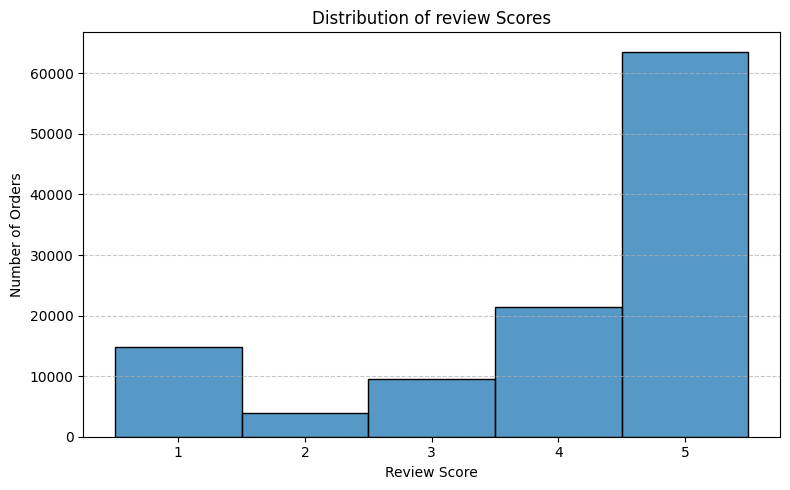

In [23]:
# It helps us see how many low scores are actually driving the costs
plt.figure(figsize=(8,5))
sns.histplot(data['review_score'], bins=range(1, 7), discrete=True)
plt.title('Distribution of review Scores')
plt.xlabel('Review Score')
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel('Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Review Score vs. Review Cost

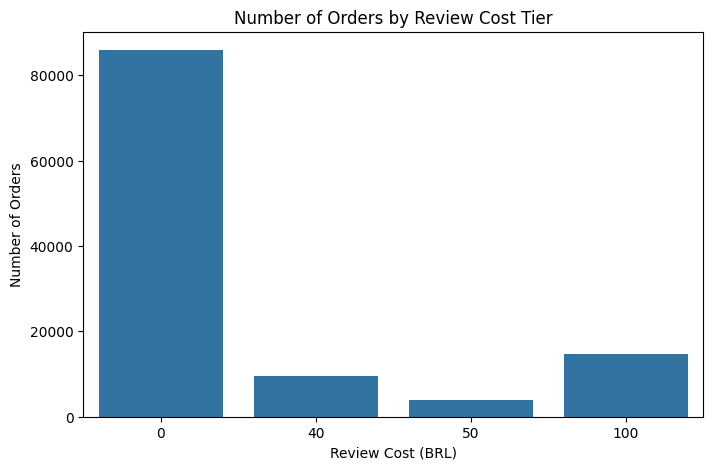

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=data['review_cost'],
    y=data['review_cost'],
    estimator=lambda x: len(x),
    errorbar=None
)
plt.title('Number of Orders by Review Cost Tier')
plt.xlabel('Review Cost (BRL)')
plt.ylabel('Number of Orders')
plt.show()


### Cumulative Cost by Score

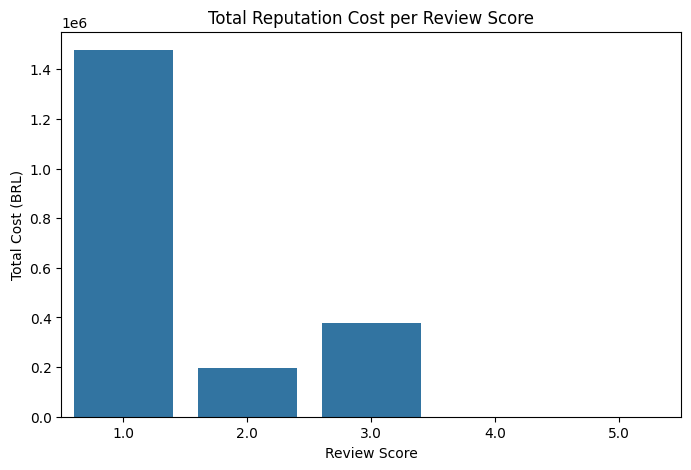

In [25]:
cost_by_score = data.groupby('review_score')['review_cost'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='review_score', y='review_cost', data=cost_by_score)
plt.title('Total Reputation Cost per Review Score')
plt.xlabel('Review Score')
plt.ylabel('Total Cost (BRL)')
plt.show()

### Profit Comparison: All vs. Good Sellers

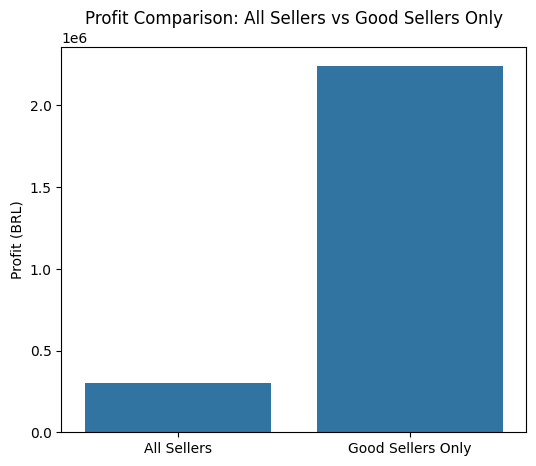

In [26]:
profits = {
    'All Sellers': 302022.93,
    'Good Sellers Only': 2243617.21
}

plt.figure(figsize=(6,5))
sns.barplot(x=list(profits.keys()), y=list(profits.values()))
plt.title('Profit Comparison: All Sellers vs Good Sellers Only')
plt.ylabel('Profit (BRL)')
plt.show()


### Reputation Cost as % of Revenue

In [27]:
revenue_total = total_revenue  
rep_cost = reputation_cost

percent_cost = rep_cost / revenue_total * 100
print(f"Reputation Cost as % of Revenue: {percent_cost:.2f}%")


Reputation Cost as % of Revenue: 71.79%


## Conclusion

**Improve Customer Satisfaction:**<br> Focus on strategies to improve customer satisfaction to increase the number of high review scores (4 and 5) and reduce the number of low review scores (1 and 2).<br>
**Address Negative Reviews:** <br>Implement measures to address the issues leading to negative reviews promptly. This could involve better customer service, quality control, or post-purchase support.<br>
**Monitor Reputation Costs:** <br>Regularly monitor the reputation costs and their impact on overall revenue. This will help in identifying trends and taking proactive measures.<br>
**Acting on IT-Cost:** <br>It is not efficient as the saving would not be substantial.

### Remarks

We are in right to question the estimation of the Cost of Reputation provided by the company considering the difference of profit with or without it. In the same way their ETA (estimated time arrival) seemed to be in much earlier that the actual time of arrival.

# Sales Prediction

We are going to make a prediction for the future sales of the company 14 days ahead.

## Understanding the Goal

We want to **predict how much money (revenue) Olist will make in the future**, based on patterns from past sales. 

## Daily Revenue: What Happened Before?

We start by adding up all the daily sales (we call it daily_revenue). 

📈 We plot this to see trends – Are we selling more over time? Are there ups and downs?

In [28]:
# What have been the volume of sales throughout time with the data we have.
monthly_sales = data.set_index('order_purchase_timestamp') \
                     .resample('ME')['price'].sum()

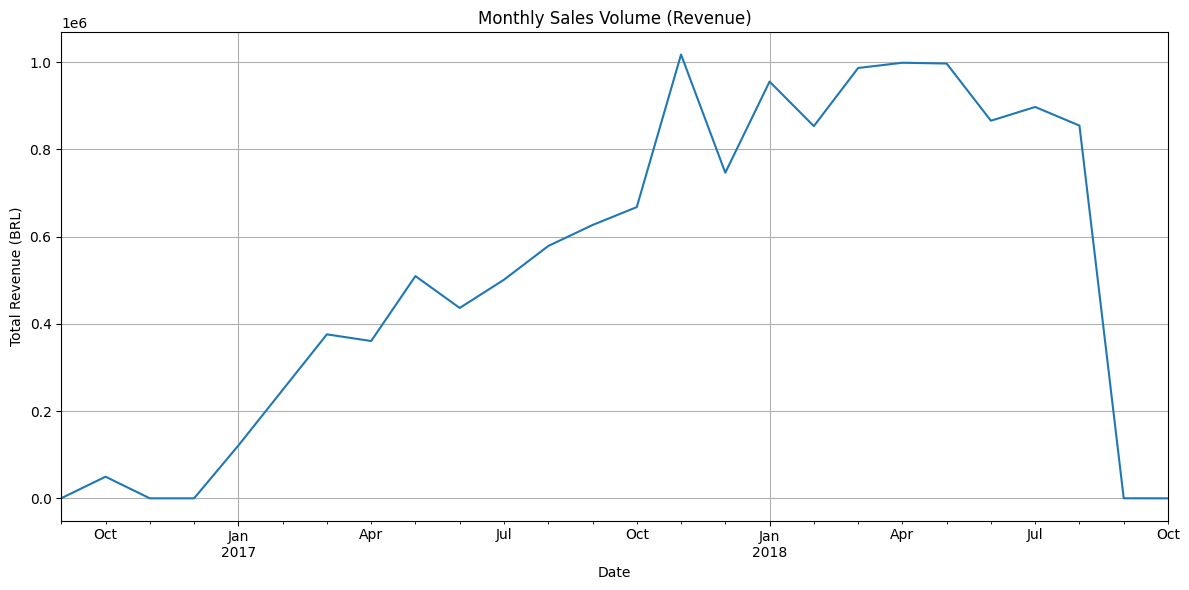

In [29]:
monthly_sales.plot(figsize=(12, 6))
plt.title("Monthly Sales Volume (Revenue)")
plt.xlabel("Date")
plt.ylabel("Total Revenue (BRL)")
plt.grid(True)
plt.tight_layout()
plt.show()

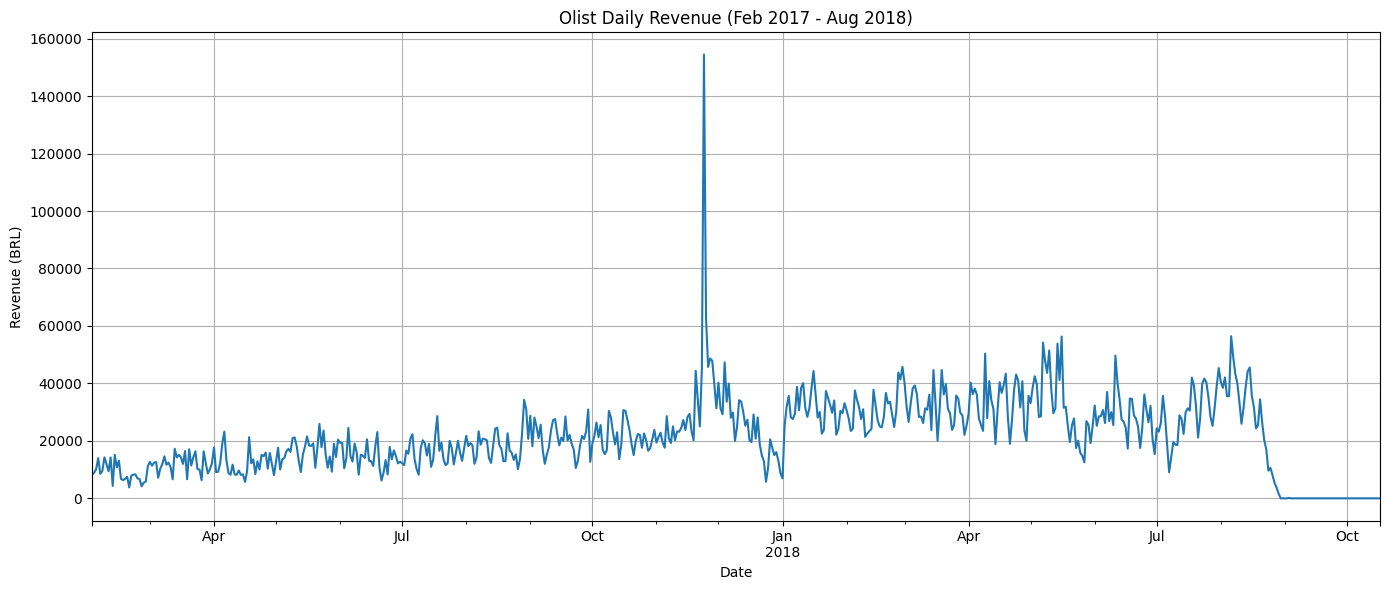

In [30]:
data_s = data[data['order_purchase_timestamp'] >= '2017-02-01']
daily_revenue = data_s.set_index('order_purchase_timestamp').resample('D')['price'].sum()

plt.figure(figsize=(14, 6))
daily_revenue.plot()
plt.title("Olist Daily Revenue (Feb 2017 - Aug 2018)")
plt.xlabel("Date")
plt.ylabel("Revenue (BRL)")
plt.grid(True)
plt.tight_layout()
plt.show()

Right away, what catches the most attention in 'Olist Daily Revenue' is the great spike in revenue  which actually occurred on the Black Friday of 2017, on November 24th. We can also notice that, in general, 2018 revenues are higher than in 2017.

## Smoothing the Revenue

Sales can be noisy – for example, a big promotion might spike revenue for one day. To better see the general direction, we use a rolling average (like looking at the average of 20 days at a time) to smooth out the noise.

This helps us focus on long-term behavior instead of short-term surprises.



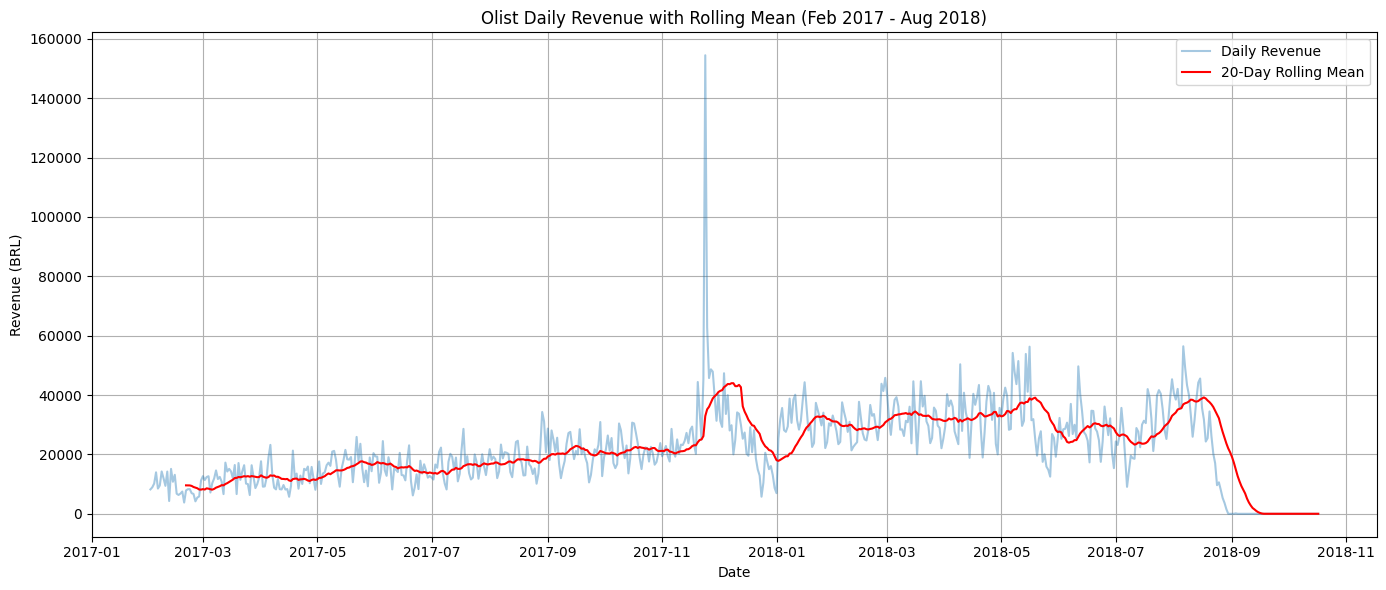

In [31]:
window_size = 20

# Compute rolling mean to smooth the curves to reduce the impact of short-terms fluctuation
smooth_daily_revenue = np.convolve(daily_revenue, np.ones(window_size)/window_size, mode='valid')

smoothed_index = daily_revenue.index[window_size - 1:]

plt.figure(figsize=(14, 6))

# Original time series
plt.plot(daily_revenue.index, daily_revenue, label='Daily Revenue', alpha=0.4)

# Smoothed line
plt.plot(smoothed_index, smooth_daily_revenue, label=f'{window_size}-Day Rolling Mean', color='red')

plt.title("Olist Daily Revenue with Rolling Mean (Feb 2017 - Aug 2018)")
plt.xlabel("Date")
plt.ylabel("Revenue (BRL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Using ARIMA to forecast the 2 next weeks of sales.

T**rain vs Test Data (What We Know vs What We Predict)**<br>
We split the data into:

Training data: what we already know (Feb 2017 to July 2018)

Testing data: the future we're trying to predict (first two weeks of August 2018)

In [33]:
# Sort the index just to be safe
daily_revenue = daily_revenue.sort_index()

# Split the data 
df_train = daily_revenue['2017-02-01':'2018-07-31']
df_test  = daily_revenue['2018-08-01':'2018-08-14']

In [34]:
# Describe data 
df_train.describe().T

count       546.000000
mean      23124.574194
std       11865.705536
min        3797.900000
25%       14659.800000
50%       21281.660000
75%       29701.687500
max      154461.880000
Name: price, dtype: float64

## Seasonal Decomposition: Finding Hidden Patterns
We use a tool that breaks our revenue into 3 parts:

- **Trend** – Are sales growing or shrinking?

- **Seasonality** – Do sales follow a repeating pattern? (like weekends or monthly cycles)

- **Residuals** – Hidden patterns we can’t explain

This gives us a deeper look into what’s really driving sales over time.

*The three main components of a time series: trend, seasonality, and residuals are given by seasonal_decompose.*

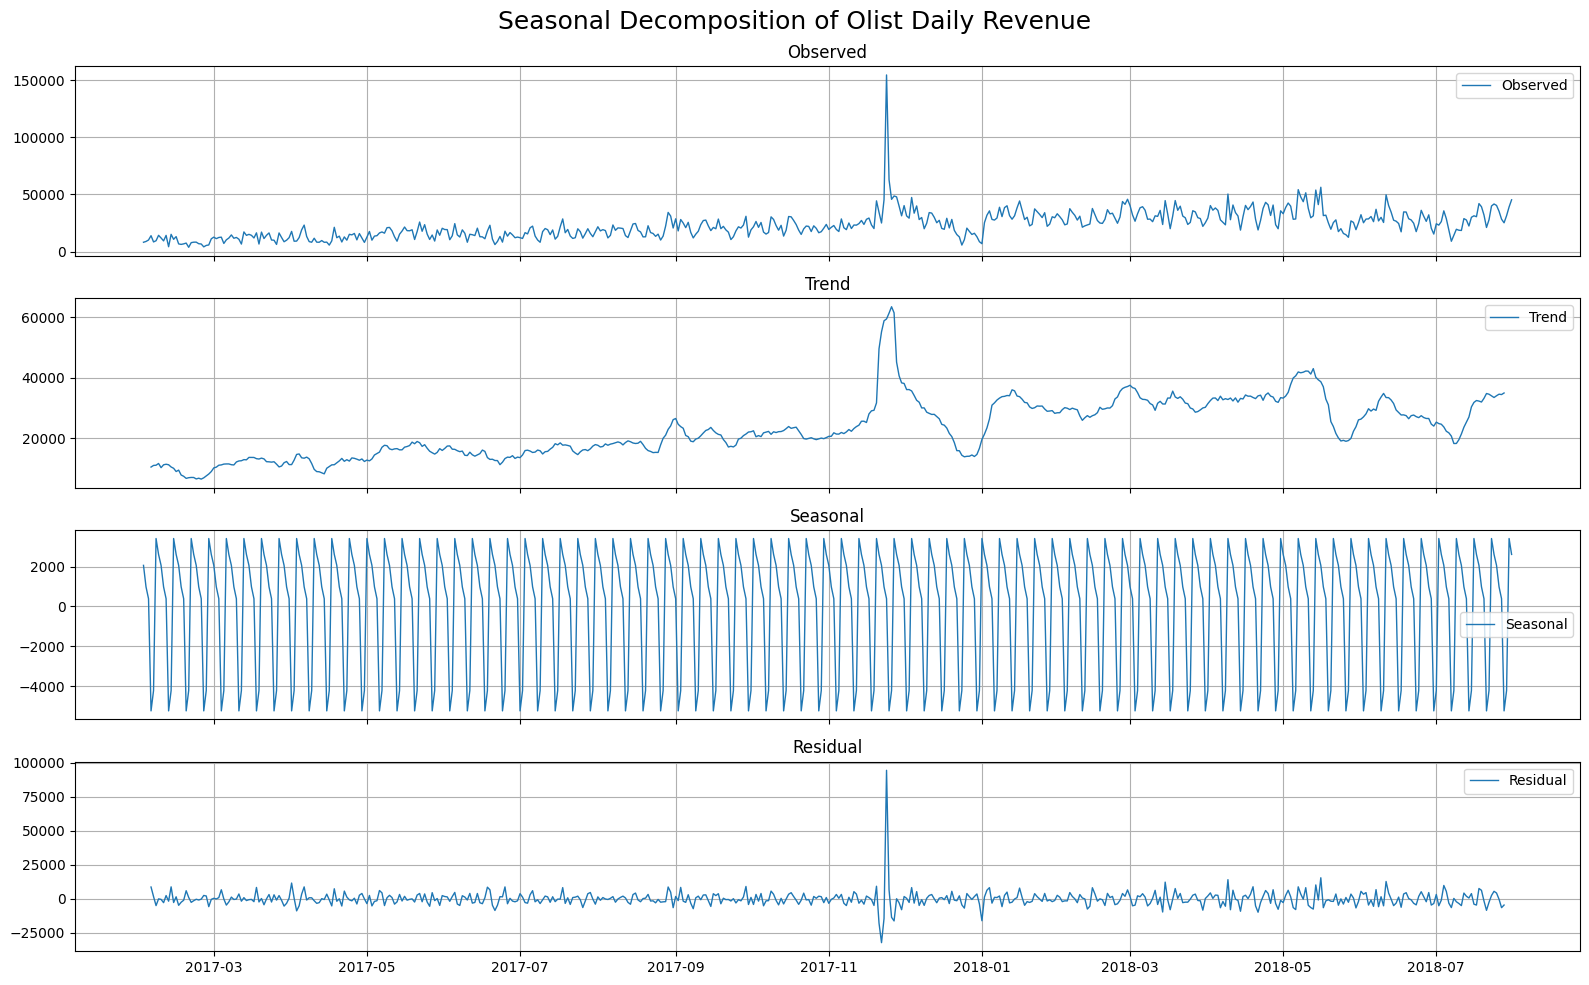

In [35]:
decomposition = seasonal_decompose(df_train, model='additive')

fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

# Observed
axes[0].plot(decomposition.observed, label='Observed', linewidth=1)
axes[0].set_title('Observed')

# Trend
axes[1].plot(decomposition.trend, label='Trend', linewidth=1)
axes[1].set_title('Trend')

# Seasonal
axes[2].plot(decomposition.seasonal, label='Seasonal', linewidth=1)
axes[2].set_title('Seasonal')

# Residual
axes[3].plot(decomposition.resid, label='Residual', linewidth=1)
axes[3].set_title('Residual')

# General plot formatting
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.suptitle("Seasonal Decomposition of Olist Daily Revenue", fontsize=18)
plt.tight_layout()  
plt.show()

- **The trend** looks like a rolling mean of about 10 days, it goes up which shows an increase in sales over time.
- **The seasonal component** shows a weekly pattern.
- **The residual** stays close to 0.

## Forecasting with ARIMA
We use a forecasting model called ARIMA that:

- Learns from the trend,

- Adjusts for repeating patterns,

- And handles randomness.

We test different versions of ARIMA to find the best one that fits our past data. Once we have it, we use it to predict what revenue will look like in August.

### Stationarity

We check for **stationarity** to make sure our forecast model doesn’t get confused by drifting or unstable data. If the data is not stationary, we "clean it up" (usually by differencing) so it's ready to predict the future.

There are two main tests we can run:

**ADF Test**: If the result is below 0.05, it means the data is stationary.

**KPSS Test**: If the result is above 0.05, it means the data is stationary.

In real life, sales might slowly grow, fluctuate with the seasons, or have random spikes — so the data often **isn’t stationary**.

To fix this, we sometimes **transform the data** (for example, by taking the difference between each day and the day before). This helps us get a more stable series that’s easier to model and forecast accurately.

In [40]:
# Augmented Dickey-Fuller test on the original data
result = adfuller(df_train)
print(f'ADF Statistic is {result[0]:.2f} and the p-value is {result[1]:.3f}')

# KPSS test on original data
result = kpss(df_train)
print(f'KPSS Statistic is {result[0]:.2f} and the p-value is {result[1]:.3f}')

ADF Statistic is -2.67 and the p-value is 0.079
KPSS Statistic is 2.63 and the p-value is 0.010


/home/romaric/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


We ran two tests to check if our time series data is stationary:

- **ADF Test**: p-value = 0.079 → We fail to reject the null hypothesis, so the series is likely *not* stationary.
- **KPSS Test**: p-value = 0.01 → We reject the null hypothesis of stationarity.

✅ Both tests suggest that our time series is **not stationary**, which means we need to **difference** it before forecasting (d=1).



In [41]:
# ADF test on the differenciated data
result = adfuller(df_train.diff().dropna())

print(f'ADF Statistic is {result[0]:.2f} and the p-value is {result[1]:.3f}')

# KPSS test on differenciated data
result = kpss(df_train.diff().dropna())

print(f'KPSS Statistic is {result[0]:.2f} and the p-value is {result[1]:.3f}')

ADF Statistic is -7.79 and the p-value is 0.000
KPSS Statistic is 0.03 and the p-value is 0.100


/home/romaric/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


With these results we can confirm that the series **needs to be differentiated one time (d=1) to be stationary** and to be used for forecasting.<br>
*See the graphes below*

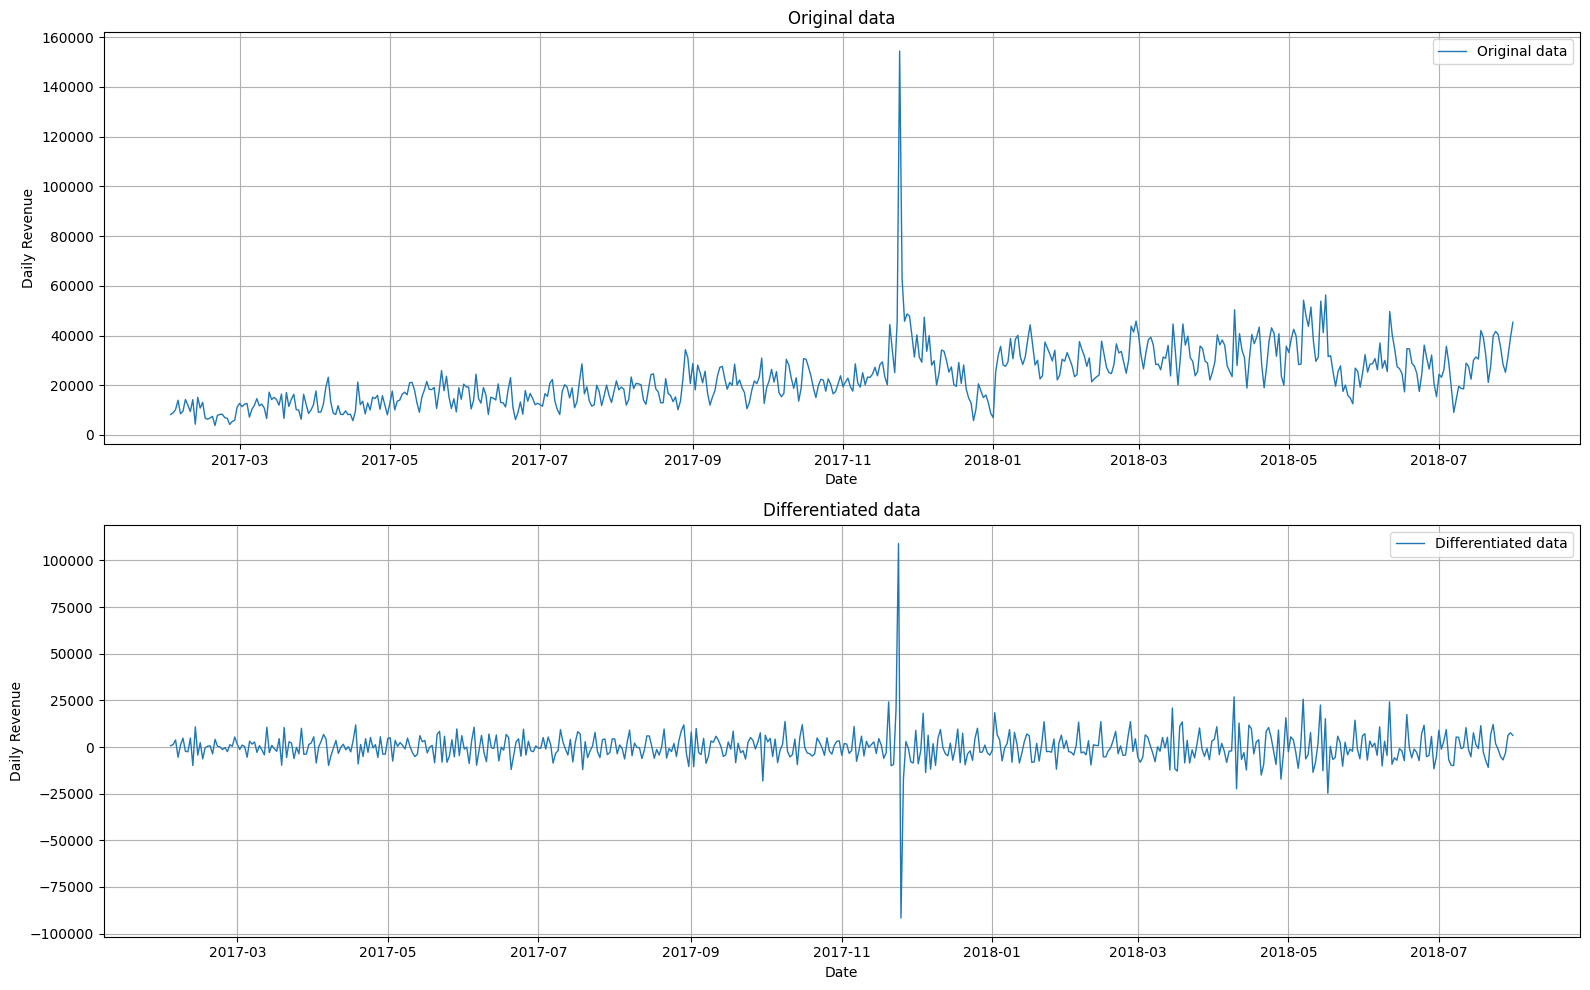

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Original data
axes[0].plot(df_train, label='Original data', linewidth=1)
axes[0].set_title('Original data')

# Differentiated data
axes[1].plot(df_train.diff(), label='Differentiated data', linewidth=1)
axes[1].set_title('Differentiated data')

# General plot formatting
for ax in axes:
    ax.set_ylabel('Daily Revenue')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True)

plt.tight_layout()  
plt.show()

### Pre-analysis of ACF and PACF
We run a pre-analysis of Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) on the differentiated series to get the best training indicators for our model.

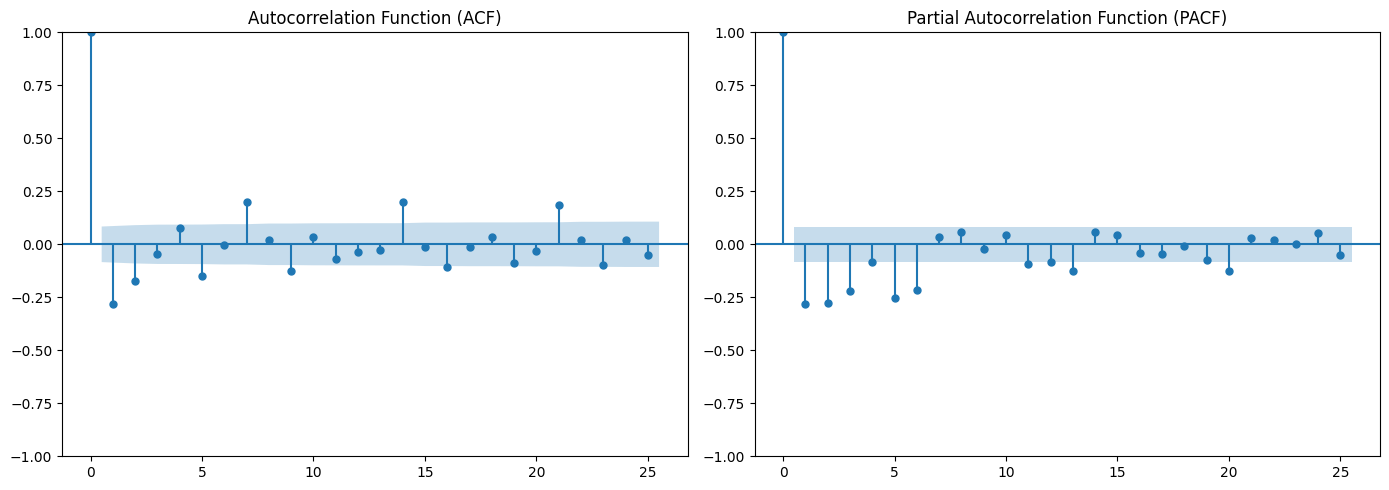

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# ACF
plot_acf(df_train.diff().dropna(), lags=25, alpha=0.05, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(df_train.diff().dropna(), lags=25, alpha=0.05, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Looking at the ACF plot, we notice that the spikes at 7, 14, and 21 days stand out. Since our data is tracked daily, this suggests a weekly pattern — meaning what happens this week is often similar to what happened last week.

The PACF plot shows a kind of wavy, repeating pattern (like a sine wave), which often happens when the data has a strong regular cycle — again, hinting at that weekly trend.

This tells us that we’re likely working with a time series where past values have an influence over time, especially in cycles of 7 days. Based on this, **it makes sense to explore an ARIMA model**, probably something like an *ARIMA(0, d, q*).

### Auto Arima
It is useful to find the optimal ARIMA model, we'll use it to find the values of p and q. 

In [59]:
fit_arima = auto_arima(
    df_train,                       # dataset
    max_p=3,                        # limiting the number of autoregressive terms so the model don't overfit
    max_q=3,                        # limiting the number of moving average terms so the model don't overfit
    m=7,                            # number of periods in the seasonal cycle
    seasonal=True,                  # try for seasonal data
    seasonal_test='ocsb',           # use the OCSB test for seasonality
    d=1,                            # number of differencing equals to 1 because of ADF and KPSS results
    trace=False,                    # to not print the progress of the model
    information_criterion='bic',    # choose the best model based on Bayesian information criterion
    stepwise=False                  # testing all possible combinations
)

In [60]:
fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  546
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -5652.947
Date:                            Sat, 17 May 2025   AIC                          11317.894
Time:                                    12:40:22   BIC                          11343.699
Sample:                                02-01-2017   HQIC                         11327.982
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.2140      5.755      2.644      0.008       3.934      26.494
ar.L1          0.4827      0.025     19.485      0.000       0.434       0.531
ma.L1         -0.9900      0.013    -75.547      0.000      -1.016      -0.964
ar.S.L7        0.2169      0.037      5.890      0.000       0.145       0.289
ar.S.L14       0.1315      0.034      3.826      0.000       0.064       0.199
sigma2      6.828e+07   1.95e-05    3.5e+12      0.000    6.83e+07    6.83e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):            263299.40
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             7.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.07e+28. Standard errors may be unstable.
"""

### FORECAST
We will use this fitted model to forecast the next 14 days of revenue and confidence intervals limit.

In [61]:
forecast, conf_limits = fit_arima.predict(n=14, return_conf_int=True)

## Comparing Prediction to Reality
After forecasting, we compare our predicted values with the real sales data from August to see:

- Did we guess well?

- Where were we off?

📉 This helps us improve future predictions.

## Conclusion: Why This Matters
This whole process helps a company like Olist:

- Plan for the future,

- Prepare stock and deliveries,

- Make smarter decisions.

📊 Forecasting turns historical data into real business value.